In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import os
from config import data_path

/Users/annahuang/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/annahuang/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [3]:
data = pd.read_csv(os.path.join(data_path, "sqzme.csv"), index_col='date')
data.index = pd.to_datetime(data.index)
data

,price,dix,gex
date,,,
2011-05-02,1361.219971,0.378842,1.897313e+09
2011-05-03,1356.619995,0.383411,1.859731e+09
2011-05-04,1347.319946,0.392122,1.717764e+09
2011-05-05,1335.099976,0.405457,1.361864e+09
2011-05-06,1340.199951,0.418649,1.490329e+09
...,...,...,...
2025-03-31,5611.850000,0.445360,7.999530e+08
2025-04-01,5633.070000,0.493397,1.504443e+09
2025-04-02,5670.970000,0.521978,2.134591e+09


Simple Statistics

count    3.504000e+03
mean     2.815697e+09
std      2.786469e+09
min     -7.496823e+09
25%      1.222242e+09
50%      2.384672e+09
75%      3.822328e+09
max      2.421867e+10
Name: gex, dtype: float64

skewness： 2.0408682238825477
kurtosis： 9.142923850448287


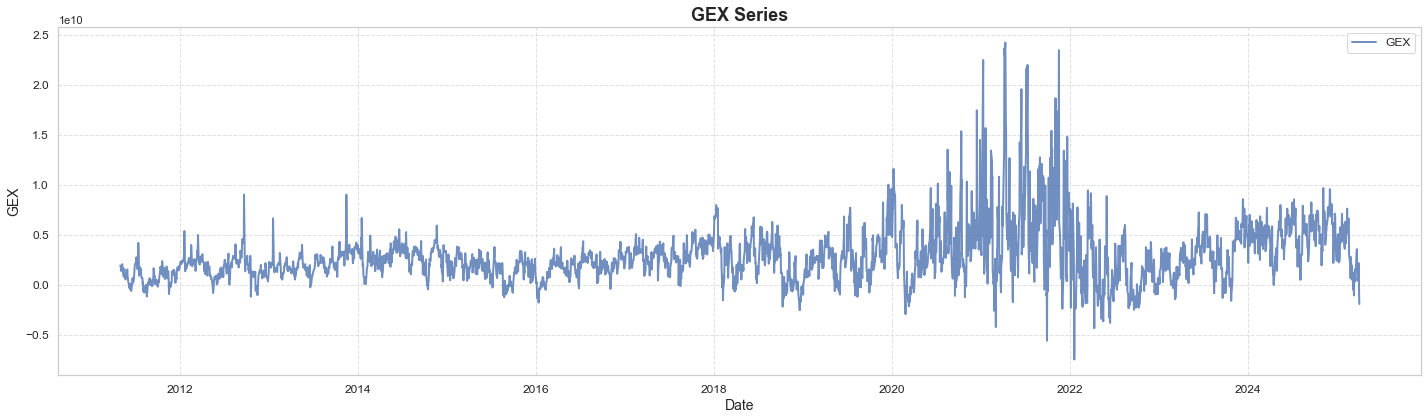

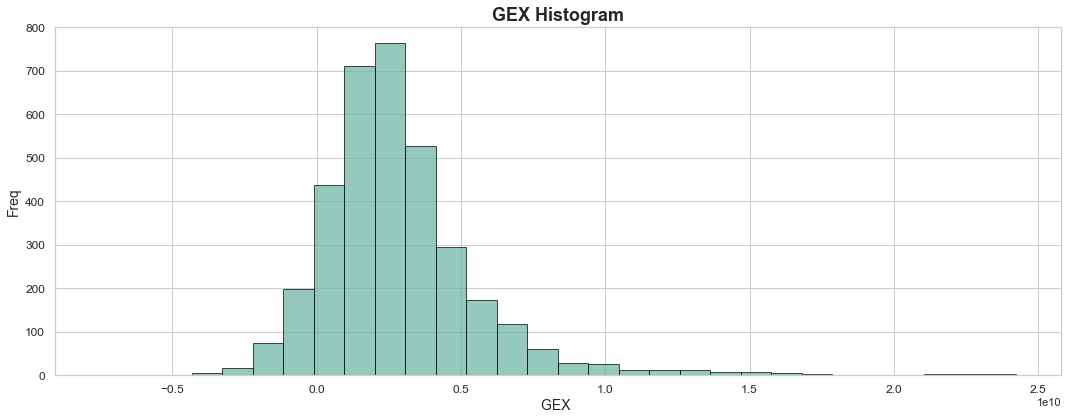

<Figure size 576x576 with 0 Axes>

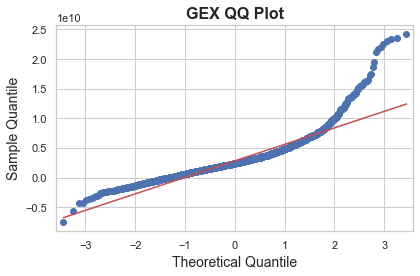

In [4]:
gex_series = data['gex'].dropna()

# Simple Statistics
print("Simple Statistics\n")
print(gex_series.describe())
print("\nskewness：", gex_series.skew())
print("kurtosis：", gex_series.kurtosis())

# GEX series Overview（2020年波动加剧的地方要分析一下）
import seaborn as sns
import matplotlib.dates as mdates

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(
    gex_series.index.date, 
    gex_series.values,
    linewidth=2.0,
    markersize=4,
    alpha=0.8,
    label="GEX"
)
ax.set_title("GEX Series", fontsize=18, fontweight='bold')
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("GEX", fontsize=14)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax.legend(fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Histogram of GEX series
sns.set_theme(style="whitegrid")

plt.figure(figsize=(15, 6))
plt.hist(gex_series.values, bins=30, color="#69b3a2", edgecolor="black", alpha=0.7)

plt.title("GEX Histogram", fontsize=18, fontweight='bold')
plt.xlabel("GEX ", fontsize=14)
plt.ylabel("Freq", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

# QQ Plot for Normality（厚尾特征）
plt.figure(figsize=(8, 8))
qqplot(gex_series.values, line='s', marker='o')

plt.title("GEX QQ Plot", fontsize=16, fontweight='bold')
plt.xlabel("Theoretical Quantile", fontsize=14)
plt.ylabel("Sample Quantile", fontsize=14)

plt.tight_layout()
plt.show()

In [5]:
from statsmodels.tsa.stattools import adfuller, kpss

# Augmented Dickey-Fuller Test for Stationary check
adf_result = adfuller(gex_series)
print("ADF Test Result:")
print(f" ADF stats: {adf_result[0]:.4f}")
print(f" p-value: {adf_result[1]:.4f}")

if adf_result[1] < 0.05:
    print(' Series stationary')
else:
    print(' Series non-stationary')

# KPSS Test：这里不平稳，考虑是因为结构性断点，2020年波动太大了。different之后平稳，但是gex差又不是我们想要的值。

kpss_stat, kpss_p, kpss_lags, kpss_crit = kpss(gex_series, regression="c", nlags="auto")
print("\nKPSS Test Result:")
print(f"  KPSS stats: {kpss_stat:.4f}")
print(f"  p-value: {kpss_p:.4f}")
if kpss_p > 0.05:
    print('  Series stationary')
else:
    print('  Series non-stationary')

# data_df = (gex_series - gex_series.shift(1)).fillna(0)    # stationary for both test

ADF Test Result:
 ADF stats: -6.3958
 p-value: 0.0000
 Series stationary

KPSS Test Result:
  KPSS stats: 2.0671
  p-value: 0.0100
  Series non-stationary


<Figure size 1008x720 with 0 Axes>

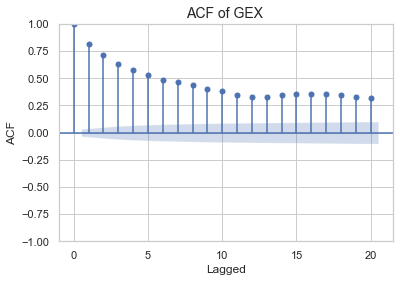

<Figure size 1008x720 with 0 Axes>

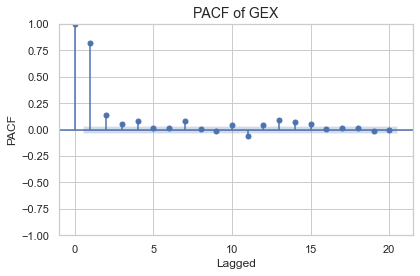

'\n1. ACF图展现出逐渐衰减趋势，PACF图在第一阶有明显尖峰特征且随后迅速回落。注意到ACF在前几阶内仍保持一定的正相关关系，意味着数据具有一定持久性或“记忆性”（金融数据特征）。\n\n2. 从PACF图上看第一滞后项lagged 1 value占主导，考虑AR(1)过程，一般足以用于判断偏离程度及回归速度（半衰期）。\n\n3. 如果在AR(1)拟合后，自回归系数beta在区间(0, 1)内，且p值显著，叠加adf/kpss检验，可以证明数据存在一定的均值回归特性。\n\n4. 这里我们的kpss检验其实没通过，可能的原因：一是可能均值不稳定，二是数据的波动可能不是短期的波动然后回归到均值，可能是长期趋势的变化。\n\n'

In [6]:
sns.set_theme(style="whitegrid")

# ACF Plot
plt.figure(figsize=(14, 10))
plot_acf(gex_series, lags=20, alpha=0.05)
plt.title("ACF of GEX ", fontsize=14)
plt.xlabel("Lagged", fontsize=12)
plt.ylabel("ACF", fontsize=12)

# PACF Plot
plt.figure(figsize=(14, 10))
plot_pacf(gex_series, lags=20, alpha=0.05, method='ywm')
plt.title("PACF of GEX", fontsize=14)
plt.xlabel("Lagged", fontsize=12)
plt.ylabel("PACF", fontsize=12)

plt.tight_layout()
plt.show()

"""
1. ACF图展现出逐渐衰减趋势，PACF图在第一阶有明显尖峰特征且随后迅速回落。注意到ACF在前几阶内仍保持一定的正相关关系，意味着数据具有一定持久性或“记忆性”（金融数据特征）。

2. 从PACF图上看第一滞后项lagged 1 value占主导，考虑AR(1)过程，一般足以用于判断偏离程度及回归速度（半衰期）。

3. 如果在AR(1)拟合后，自回归系数beta在区间(0, 1)内，且p值显著，叠加adf/kpss检验，可以证明数据存在一定的均值回归特性。

4. 这里我们的kpss检验其实没通过，可能的原因：一是可能均值不稳定，二是数据的波动可能不是短期的波动然后回归到均值，可能是长期趋势的变化。

"""

In [7]:
# AR(1) model: GEX_t = const + beta * GEX_{t-1} + error
df_ar = pd.DataFrame({"GEX": gex_series})
df_ar["GEX_Lag1"] = df_ar["GEX"].shift(1)
df_ar = df_ar.dropna()

X = sm.add_constant(df_ar["GEX_Lag1"])
model = sm.OLS(df_ar["GEX"], X).fit()
print(model.summary())

# Half-Life：-log(2) / log(beta)
beta_est = model.params["GEX_Lag1"]
if beta_est < 1 and beta_est > 0:
    half_life = -np.log(2) / np.log(beta_est)
    print(f"\nHalf-Life: {half_life:.4f} periods")
else:
    print("no mean-reverting")

                            OLS Regression Results                            
Dep. Variable:                    GEX   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     7058.
Date:                Sun, 13 Apr 2025   Prob (F-statistic):               0.00
Time:                        10:29:35   Log-Likelihood:                -79220.
No. Observations:                3503   AIC:                         1.584e+05
Df Residuals:                    3501   BIC:                         1.585e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.119e+08   3.86e+07     13.272      0.0

       lb_stat     lb_pvalue
1    41.490895  1.184212e-10
2    42.594200  5.633613e-10
3    43.713113  1.736515e-09
4    55.884634  2.120016e-11
5    61.811112  5.131085e-12
6    63.041224  1.082605e-11
7    80.087257  1.322203e-14
8    90.873529  3.091086e-16
9    90.927453  1.060493e-15
10  124.473170  6.241974e-22


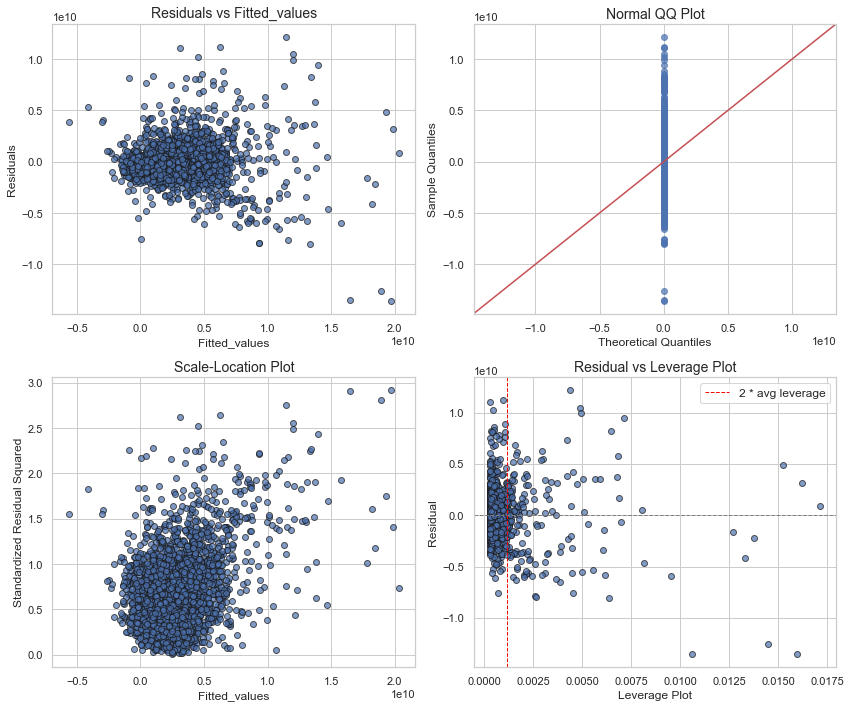

'\n1.\t非正态和重尾：QQ 图明显残差分布偏离正态，且存在极端值，常见于金融数据。\n2.\t可能的异方差：Scale-Location 图显示散点分布较为离散，不排除异方差可能性。\n3.\t高杠杆点或异常值：Residual vs Leverage 图中有个别高杠杆点。\n4.\t数值量级问题：由于 GEX 数值可能非常大（图中坐标达到 1e10 级），在做回归与残差诊断时易产生数值不稳定。\n\n现在我们的结果里面kpss显示不平稳，残差显示厚尾，对原序列建立ar（1）模型之后lb test没通过，这种情况下怎么继续验证均值回归，还是直接做策略？\n信号过滤与组合确认：将 KPSS 和厚尾指标作为一种辅助信号，当它们同时出现时，提示市场可能出现大幅度偏离。结合均值回归的Z-score一起确认交易信号。\n实际验证结果：用厚尾帮助识别signal的策略效果反而更差，可能这个异常值就是我们需要去识别并交易的点。\n\n但是gex本身没办法判断交易信号，并且存在gex之后才出现明显趋势的可能性。考虑到spy是一种强趋势资产，使用一些趋势指标帮助判断方向试试。\n'

In [8]:
# Residuals Analysis

# Ljung-Box test
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(model.resid, lags=10, return_df=True)
print(lb_test)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Residuals vs Fitted_values
axes[0, 0].scatter(model.fittedvalues, model.resid, alpha=0.7, edgecolors='k')
axes[0, 0].set_xlabel("Fitted_values", fontsize=12)
axes[0, 0].set_ylabel("Residuals", fontsize=12)
axes[0, 0].set_title("Residuals vs Fitted_values", fontsize=14)

# 2. Normal QQ Plot
sm.qqplot(model.resid, line='45', ax=axes[0, 1], alpha=0.7, marker='o', markersize=6)
axes[0, 1].set_title("Normal QQ Plot", fontsize=14)

# 3. Scale-Location 图（Standardized Residual Squared vs Fitted_values）
standardized_resid = model.get_influence().resid_studentized_internal
sqrt_std_resid = np.sqrt(np.abs(standardized_resid))
axes[1, 0].scatter(model.fittedvalues, sqrt_std_resid, alpha=0.7, edgecolors='k')
axes[1, 0].set_xlabel("Fitted_values", fontsize=12)
axes[1, 0].set_ylabel("Standardized Residual Squared", fontsize=12)
axes[1, 0].set_title("Scale-Location Plot", fontsize=14)

# 4. Residual vs Leverage Plot (with Cook’s Distance information)
influence = model.get_influence()
leverage = influence.hat_matrix_diag
cooks = influence.cooks_distance[0]
axes[1, 1].scatter(leverage, model.resid, alpha=0.7, edgecolors='k')
axes[1, 1].set_xlabel("Leverage Plot", fontsize=12)
axes[1, 1].set_ylabel("Residual", fontsize=12)
axes[1, 1].set_title("Residual vs Leverage Plot", fontsize=14)

axes[1, 1].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[1, 1].axvline(2 * np.mean(leverage), color='red', linestyle='--', linewidth=1, label="2 * avg leverage")
axes[1, 1].legend(fontsize=12)

plt.tight_layout()
plt.show()

"""
1.	非正态和重尾：QQ 图明显残差分布偏离正态，且存在极端值，常见于金融数据。
2.	可能的异方差：Scale-Location 图显示散点分布较为离散，不排除异方差可能性。
3.	高杠杆点或异常值：Residual vs Leverage 图中有个别高杠杆点。
4.	数值量级问题：由于 GEX 数值可能非常大（图中坐标达到 1e10 级），在做回归与残差诊断时易产生数值不稳定。

现在我们的结果里面kpss显示不平稳，残差显示厚尾，对原序列建立ar（1）模型之后lb test没通过，这种情况下怎么继续验证均值回归，还是直接做策略？
信号过滤与组合确认：将 KPSS 和厚尾指标作为一种辅助信号，当它们同时出现时，提示市场可能出现大幅度偏离。结合均值回归的Z-score一起确认交易信号。
实际验证结果：用厚尾帮助识别signal的策略效果反而更差，可能这个异常值就是我们需要去识别并交易的点。

但是gex本身没办法判断交易信号，并且存在gex之后才出现明显趋势的可能性。考虑到spy是一种强趋势资产，使用一些趋势指标帮助判断方向试试。
"""

In [9]:
import yfinance as yf
import ta 

spy = yf.download("SPY", start="2011-05-02", end="2025-04-04")
df_spy = spy[['Close']].rename(columns={'Close': 'SPY'})
df_spy = df_spy['SPY']
df_spy.dropna(inplace=True)

gex_series = data['gex'].dropna()
df = pd.DataFrame({"SPY": df_spy["SPY"], "GEX": gex_series})
df = df.dropna()

# Z-scores for outliers
window = 120  
df["GEX_RollingMean"] = df["GEX"].rolling(window=window).mean()
df["GEX_RollingStd"]  = df["GEX"].rolling(window=window).std()
df["GEX_Zscore"] = (df["GEX"] - df["GEX_RollingMean"]) / df["GEX_RollingStd"]

# Kurtosis
df["GEX_Kurtosis"] = df["GEX"].rolling(window=window).kurt()
kurt_threshold = 1.0  # Rolling Kurtosis > 1 : heavy tail

# Moving Average for Market Condition 
ma_window = 120
df["SPY_MA"] = df["SPY"].rolling(window=ma_window).mean()
trend_threshold = 0.05      # Trend filter threshold
df["Trend_Filter"] = (abs(df["SPY"] - df["SPY_MA"]) / df["SPY_MA"] < trend_threshold).astype(int)

# 10 days RSI: determine buy/sell direction, 
df["RSI"] = ta.momentum.rsi(df["SPY"], window=10)   

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [10]:
# Signal Construction

pos_threshold = 1.0  
neg_threshold = -1.0  

df["Signal_GEX"] = 0
df.loc[(df["GEX"] > 0) & (df["GEX_Zscore"] > pos_threshold), "Signal_GEX"] = -1     # When GEX is positive and Z-score > 1, there is a sell signal
df.loc[(df["GEX"] < 0) & (df["GEX_Zscore"] < neg_threshold), "Signal_GEX"] = 1      # When GEX is negative and Z-score < -1, there is a buy signal

# Use RSI to confirm the direction:
def confirm_signal(row):
    if row["Signal_GEX"] == 1 and row["RSI"] < 30:      # When Signal_GEX is 1, RSI < 30 is required for this buy signal;
        return 1
    elif row["Signal_GEX"] == -1 and row["RSI"] > 80:       # When Signal_GEX is -1, RSI > 70 is required for this sell signal;
        return -1
    else:
        return 0                # If the RSI condition is not met, the signal is set to 0

df["Confirmed_Signal"] = df.apply(confirm_signal, axis=1)

df["Signal"] = df["Confirmed_Signal"]       # Here I use the confirmed signal directly, but we can choose to amplify the signal by trend filters when the trend is weak

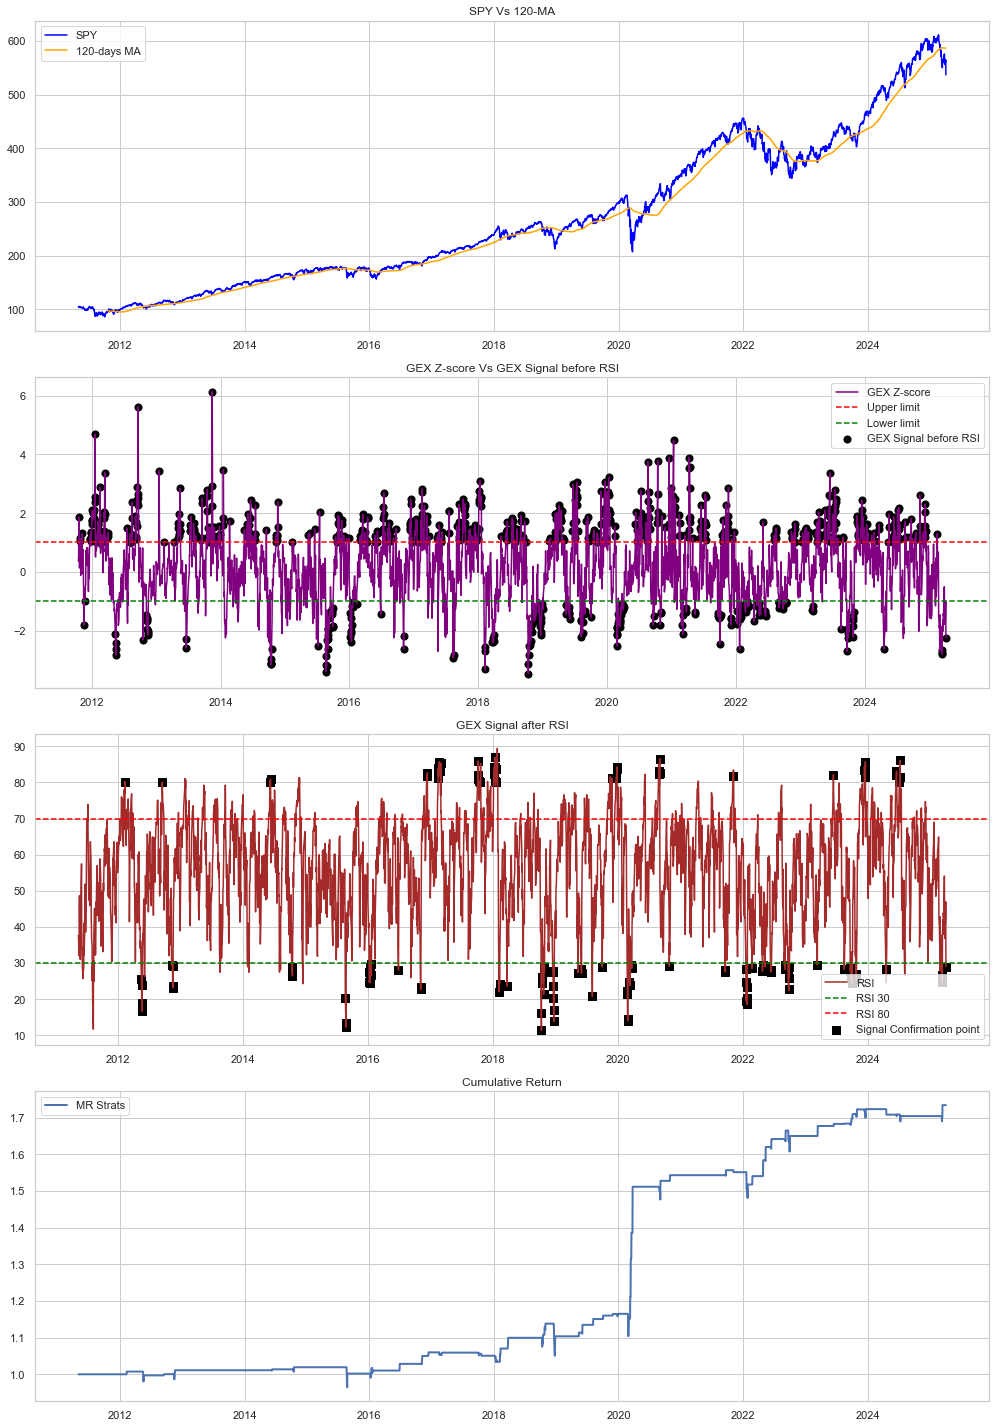

                   SPY      SPY_MA        RSI           GEX  GEX_Zscore  \
2025-03-21  563.979980  586.595906  42.911335  1.528379e+09   -1.399806   
2025-03-24  574.080017  586.647866  52.871385  3.359703e+09   -0.596492   
2025-03-25  575.460022  586.692363  54.087454  3.543468e+09   -0.507177   
2025-03-26  568.590027  586.722172  47.331903  2.084829e+09   -1.123992   
2025-03-27  567.080017  586.737410  45.930866  2.057823e+09   -1.121162   
2025-03-28  555.659973  586.666092  36.781843  4.004214e+08   -1.792147   
2025-03-31  559.390015  586.583132  41.043744  7.999530e+08   -1.589706   
2025-04-01  560.969971  586.556230  42.856815  1.504443e+09   -1.277703   
2025-04-02  564.520020  586.514446  46.931278  2.134591e+09   -0.999069   
2025-04-03  536.700012  586.207955  28.954742 -1.003998e+09   -2.236618   

            GEX_Kurtosis  Signal_GEX  Confirmed_Signal  Signal  Cum_Strategy  
2025-03-21     -0.376942           0                 0       0      1.733903  
2025-03-24     -

In [11]:
# Back-Testing
df["SPY_Returns"] = df["SPY"].pct_change()
df["Strategy_Returns"] = df["Signal"].shift(1) * df["SPY_Returns"]
df["Cum_SPY"] = (1 + df["SPY_Returns"]).cumprod()
df["Cum_Strategy"] = (1 + df["Strategy_Returns"]).cumprod()

# Plot
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(4, 1, figsize=(14,20))

# SPY Vs 120-days MA
axs[0].plot(df.index.date, df["SPY"].values, label="SPY", color="blue")
axs[0].plot(df.index.date, df["SPY_MA"].values, label="120-days MA", color="orange")
axs[0].set_title("SPY Vs 120-MA")
axs[0].legend()

# (2) GEX Z-score 与 GEX Signals
axs[1].plot(df.index.date, df["GEX_Zscore"].values, label="GEX Z-score", color="purple")
axs[1].axhline(pos_threshold, color="red", linestyle="--", label="Upper limit")
axs[1].axhline(neg_threshold, color="green", linestyle="--", label="Lower limit")
signal_points = df[df["Signal_GEX"] != 0]
axs[1].scatter(signal_points.index, signal_points["GEX_Zscore"], color="black", marker="o", s=50, label="GEX Signal before RSI")
axs[1].set_title("GEX Z-score Vs GEX Signal before RSI")
axs[1].legend()

# (3) GEX Signal after RSI
axs[2].plot(df.index.date, df["RSI"].values, label="RSI", color="brown")
axs[2].axhline(30, color="green", linestyle="--", label="RSI 30")
axs[2].axhline(70, color="red", linestyle="--", label="RSI 80")
confirm_points = df[df["Confirmed_Signal"] != 0]
axs[2].scatter(confirm_points.index, confirm_points["RSI"], color="black", marker="s", s=50, label="Signal Confirmation point")
axs[2].set_title("GEX Signal after RSI")
axs[2].legend()

# (4) Cumulative Return
#axs[3].plot(df.index.date, df["Cum_SPY"].values, label="SPY Buy & Hold", linewidth=2)
axs[3].plot(df.index.date, df["Cum_Strategy"].values, label="MR Strats", linewidth=2)
axs[3].set_title("Cumulative Return")
axs[3].legend()

plt.tight_layout()
plt.show()

print(df[["SPY", "SPY_MA", "RSI", "GEX", "GEX_Zscore", "GEX_Kurtosis", "Signal_GEX", "Confirmed_Signal", "Signal", "Cum_Strategy"]].tail(10))

In [12]:
# Total transactions
df['Signal'].value_counts()

Signal
 0    3362
 1      93
-1      48
Name: count, dtype: int64

In [13]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df_plot = df[['SPY', 'Strategy_Returns', 'Signal']]

# Calculate cumulative PnL
df_plot['cum_pnl'] = (1 + df_plot["Strategy_Returns"]).cumprod()

# Create interactive plot with plotly
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add Cumulative PnL on primary y-axis
fig.add_trace(
    go.Scatter(
        x=df_plot.index, 
        y=df_plot['cum_pnl'], 
        name='Strategy PnL',
        line=dict(color='black', width=2)
    ),
    secondary_y=False
)

# Add SPY line on secondary y-axis
fig.add_trace(
    go.Scatter(
        x=df_plot.index, 
        y=df_plot['SPY'], 
        name='SPY',
        line=dict(color='gray', width=2)
    ),
    secondary_y=True
)

# Plot long straddle trades
long_days = df_plot[df_plot['Signal'] == 1]
fig.add_trace(
    go.Scatter(
        x=long_days.index, 
        y=long_days['cum_pnl'], 
        mode='markers',
        name='Long Position',
        marker=dict(color='green', size=8)
    ),
    secondary_y=False
)

# Plot short straddle trades
short_days = df_plot[df_plot['Signal'] == -1]
fig.add_trace(
    go.Scatter(
        x=short_days.index, 
        y=short_days['cum_pnl'], 
        mode='markers',
        name='Short Position',
        marker=dict(color='red', size=8)
    ),
    secondary_y=False
)

# Update layout
fig.update_layout(
    title="MR Strategy vs. SPY",
    xaxis_title="Date",
    legend=dict(x=1.05, y=0.99),
    hovermode="x unified",
    template="plotly_white",
    width=1000,
    height=600
)

# Update y-axes titles
fig.update_yaxes(title_text="Strategy PnL (%)", secondary_y=False)
fig.update_yaxes(title_text="SPY Price", secondary_y=True)

fig.show()

In [26]:
# 1. PnL
final_cum_return = df["Cum_Strategy"].iloc[-1]
print("Cumulative Return(PnL): ", final_cum_return)

# 2. Annualized Sharpe Ratio, assume risk free is zero.
strategy_returns = df['Strategy_Returns'].dropna()
mean_return = strategy_returns.mean()
std_return = strategy_returns.std()
annual_sharpe = (mean_return / std_return) * np.sqrt(252)
print("Annualized Sharpe Ratio: ", annual_sharpe)

Cumulative Return(PnL):  1.7339031542036003
Annualized Sharpe Ratio:  0.7049733101539665
